# Here we created a notebook in order to reproduce Fig.2. results.

In [1]:
# Import necessary libraries

from incidence_model import *
from merge import *
import matplotlib.pyplot as pyplot
import numpy as np

#fixed parameters of the model cf. Eq. 15 
#number of cells produced of tissue's lifetime 
N=1e10
#number of stem cells 
N0=1.
#tissue life time in years
tlife=90
#tissue development time in years
tdev=10
#cell produced per day
cells_per_day=N/365./(tlife-tdev)
mu=10**(-5)
n=15
g=4.
ss=0.1
d=int(ceil( 1. / ss / (g-1.) ))

def mc(g,s): # critical number of mutations
    return int(ceil( 1. / s / (g-1.) ))
def sc(g,d): #critical mutation strength
    return 1. / (g-1.) * 1. / float(d)

def Di(tlife, n, g): # Divisional load 
    return tlife * power(g,-(n - 1)) + (n - 1)*(g - 1) + 1
# Probability of accumulating d number of mutations, assuming neutral mutations until the critical number is accumulated
def Ptry(mu, n, d, g, tlife): 
    return (2*mu**d/Gamma(d + 1))*g**(n - 1)*((Di(tlife, n, g) - 1.5)**d - ( (n - 1)*(g - 1) + 1 - 1.5)**d)

In [2]:
# define functions for the theoretical approximation in Eq.24
def ray_Pigs(mu,n,d,N,s_scheme,gs):
    pigs=ray.get([Pir.remote(mu,n,d,gi,[0,N],s_scheme) for gi in gs])
    return array([pig[-1] for pig in pigs])


def ray_Pisgs(mu,n,s,N,s_scheme,gs):
    pisgs=ray.get([Pisr.remote(mu,n,s,gi,[0,N],s_scheme) for gi in gs])
    return array([pisg[-1] for pisg in pisgs])

In [3]:
# initialize ray for parallel CPU run (only needs to be initialized once)
ray.init()

/home/domeemod/Asztal/mona_data_science/j-nb/jupyternenv/lib/python3.8/site-packages/ray/_private/services.py:238: UserWarning: Not all Ray Dashboard dependencies were found. To use the dashboard please install Ray using `pip install ray[default]`. To disable this message, set RAY_DISABLE_IMPORT_WARNING env var to '1'.
  warnings.warn(warning_message)


{'node_ip_address': '192.168.1.8',
 'raylet_ip_address': '192.168.1.8',
 'redis_address': '192.168.1.8:25683',
 'object_store_address': '/tmp/ray/session_2021-10-01_21-48-45_622179_127100/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-10-01_21-48-45_622179_127100/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2021-10-01_21-48-45_622179_127100',
 'metrics_export_port': 51325,
 'node_id': 'c993470ec74cafd45cf759a0362451fede5535d86d1804519a7a4001'}

# After importing libraries and functions were initialized, here we show how to use the functions to plot results.

In [4]:
# number of data points plotted
res=501. 
# selection scheme, can be (scd,scdd,neutral) 
#-> (mutations accumulated by symmetric divisions, symmetric differentiations or neutral mutations occur)
s_scheme="scd"
# x_range
xmin=2
xmax=5

# set mutation rate, number of levels and strenth of mutations (see SuppMat Table for parameter description)
# same parameters as used in Fig.2
mu=1e-5
n=15
s=0.1

# Number of cells generated over the lifetime of the tissue
N=1e7

# define res number of amplification factor values over a range of x_max,x_min as an array
gs = xmin + arange(res)/res*(xmax-xmin+0.1)

# calculate probabilities of accumulating d number of mutations with using equations described in section
# The probability of accumulatinf d_crit mutations 
psd1=ray_Pisgs(mu,n,s,N,s_scheme,gs)
pd1 = [ ray_Pigs(mu,n,d,N,s_scheme,gs) for d in arange(1,10)]
pd1 += [zeros(gs.size)]*5

# same with N=1e10
N=1e10
gs = xmin + arange(res)/res*(xmax-xmin+0.1)
psd2=ray_Pisgs(mu,n,s,N,s_scheme,gs)
pd2 = [ ray_Pigs(mu,n,d,N,s_scheme,gs) for d in arange(1,10)]
pd2 += [zeros(gs.size)]*5


In [5]:
# number of data points plotted
res=501.
# selection scheme, can be (scd,scdd,neutral) 
#-> (mutations accumulated by symmetric divisions, symmetric differentiations or neutral mutations occur)

s_scheme="scd"

# set mutation rate, number of levels and strenth of mutations (see SuppMat Table for parameter description)
# same parameters as used in Fig.2
mu=1e-6
n=15
s=0.1

N=1e10
# x_range
xmin=2
xmax=6

# calculate probabilities of accumulating d number of mutations with using equations described in section
# The probability of accumulating d_crit mutations, 
# for every d_crit(s,\gamma) value

gs = xmin + arange(res)/res*(xmax-xmin+0.1)
psd1=ray_Pisgs(mu,n,s,N,s_scheme,gs)
pd1 = [ ray_Pigs(mu,n,d,N,s_scheme,gs) for d in arange(1,10)]
pd1 += [zeros(gs.size)]*5

N=1e7
gs = xmin + arange(res)/res*(xmax-xmin+0.1)
psd2=ray_Pisgs(mu,n,s,N,s_scheme,gs)
pd2 = [ ray_Pigs(mu,n,d,N,s_scheme,gs) for d in arange(1,10)]
pd2 += [zeros(gs.size)]*5



## The actual plotting function

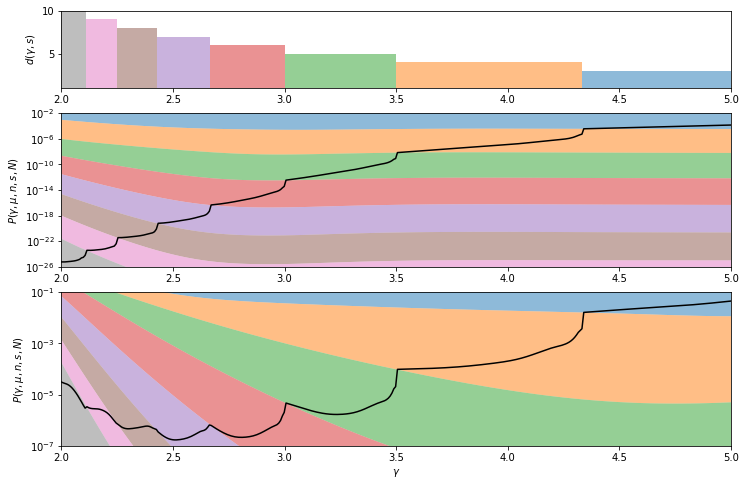

In [6]:
fig, (ax3, ax2, ax1) = pyplot.subplots(3,gridspec_kw={
                           'height_ratios': [1, 2,2]})
xmin=2
xmax=5
ymax=1e-1
alpha=0.5

ymin=10**floor(log(min(psd1))/log(10.))
ax1.set_ylim((ymin,ymax))
ax1.set_xlim((xmin,xmax))
ax1.set_yscale('log')

ax1.plot(gs, psd1, "k-"); 
[ax1.fill_between(gs, pd1[i+1], pd1[i+2], alpha=alpha) for i in arange(0,12)];

ymin=10**floor(log(min(psd2))/log(10.))
ymax=1e-2
ax2.set_ylim((ymin,ymax))
ax2.set_xlim((xmin,xmax))
ax2.set_yscale('log')

ax2.plot(gs, psd2, "k-");
[ax2.fill_between(gs, pd2[i+1], pd2[i+2], alpha=alpha) for i in arange(0,12)];

dgs = [ array([  1/s*1/ (d-1) + 1 + i * (1/s*1/(d-2)-1/s*1/(d-1)) for i in arange(100.)/99.]) for d in arange(3,12)]
ax3.set_xlim((xmin,xmax))
ax3.set_ylim((1,10))
ax1.set_xlabel("$\gamma$")
ax1.set_ylabel("$P(\gamma,\mu,n,s,N)$")
ax2.set_ylabel("$P(\gamma,\mu,n,s,N)$")
ax3.set_ylabel("$d(\gamma,s)$")
[ax3.fill_between(dgs[d],0,d+2,alpha=alpha) for d in arange(1,9)];

fig.set_size_inches(12, 8)

In [7]:
# save figure above if necessary
fig.set_size_inches(12, 8)

fig.savefig("fig2.pdf")

# Compare results with the case when  mutaitons until the accumulation of d_c are neutral using same parameters as above and in article. 

In [8]:
# plot similiarly as above but with neutral mutations (until d_crit)
res=501.
s_scheme="neutral"
xmin=2
xmax=5

mu=1e-6
n=15
s=0.1

N=1e10
gs = xmin + arange(res)/res*(xmax-xmin+0.1)
psd1=ray_Pisgs(mu,n,s,N,s_scheme,gs)
pc1 = [Ptry(mu, n, 1/(g-1)*1/s, g, N) for g in gs]
pd1 = [ ray_Pigs(mu,n,d,N,s_scheme,gs) for d in arange(1,10)]
pd1 += [zeros(gs.size)]*5

N=1e7
gs = xmin + arange(res)/res*(xmax-xmin+0.1)
psd2=ray_Pisgs(mu,n,s,N,s_scheme,gs)
pc2 = [Ptry(mu, n, 1/(g-1)*1/s, g, N) for g in gs]
pd2 = [ ray_Pigs(mu,n,d,N,s_scheme,gs) for d in arange(1,10)]
pd2 += [zeros(gs.size)]*5



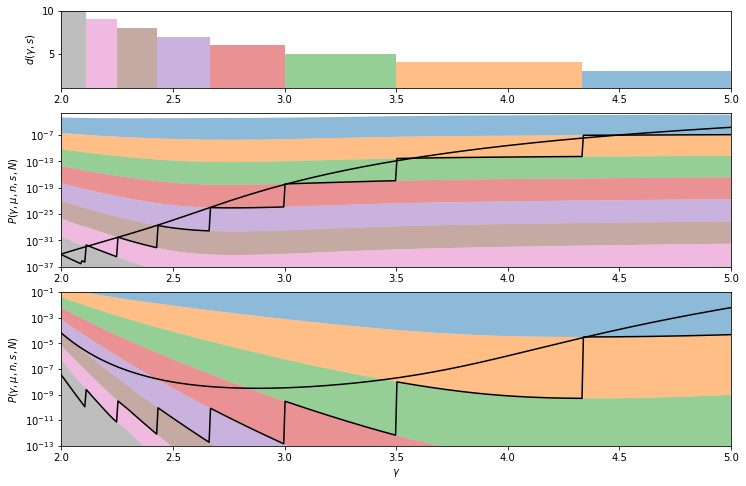

In [9]:
# Same logic applied here with plotting as above

fig, (ax3, ax2, ax1) = pyplot.subplots(3,gridspec_kw={
                           'height_ratios': [1, 2,2]})
ymax=1e-1
alpha=0.5
ymin=10**floor(log(min(psd1))/log(10.))
ax1.set_ylim((ymin,ymax))
ax1.set_xlim((xmin,xmax))
ax1.set_yscale('log')

ax1.plot(gs, pc1, "k-"); 
ax1.plot(gs, psd1, "k-"); 
[ax1.fill_between(gs, pd1[i+1], pd1[i+2], alpha=alpha) for i in arange(0,12)];

ymin=10**floor(log(min(psd2))/log(10.))
ymax=1e-2
ax2.set_ylim((ymin,ymax))
ax2.set_xlim((xmin,xmax))
ax2.set_yscale('log')

ax2.plot(gs, pc2, "k-"); 
ax2.plot(gs, psd2, "k-");
[ax2.fill_between(gs, pd2[i+1], pd2[i+2], alpha=alpha) for i in arange(0,12)];

dgs = [ array([  1/s*1/ (d-1) + 1 + i * (1/s*1/(d-2)-1/s*1/(d-1)) for i in arange(100.)/99.]) for d in arange(3,12)]
ax3.set_xlim((xmin,xmax))
ax3.set_ylim((1,10))
ax1.set_xlabel("$\gamma$")
ax1.set_ylabel("$P(\gamma,\mu,n,s,N)$")
ax2.set_ylabel("$P(\gamma,\mu,n,s,N)$")
ax3.set_ylabel("$d(\gamma,s)$")
[ax3.fill_between(dgs[d],0,d+2,alpha=alpha) for d in arange(1,9)];

fig.set_size_inches(12, 8)

In [10]:
# save figure above if necessary
fig.set_size_inches(12, 8)

fig.savefig("fig2_neutral.pdf")

# Run simulations (SuppMat section S1) to validate datapoints 


** Note that the number of intitial cells at levels ($N_k$) are estimated by the theoretical approximation for given parameters, which is  motly sufficient but sometimes not exactly optimal in order to measure the probabilities.

** Simulations can run a very long time depending on parameters for significant number of instances.
Validations were executed on a CPU cluster with hundreds of threads. 

** Running time benchmarks (highly dependent on parameters):
CPU: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz
* N = 1e10, ~tens of minutes/instance
* N = 1e9 , ~ minutes/instance
* N = 1e8 , ~ tens seconds/instance
* N = 1e7, ~seconds/instance

In [48]:
import os,sys,math
import scipy.special
import scipy.special as special
from sys import *
import time

def dc(g,s):
    return int(ceil( 1. / s / (g-1.) ))

# number of instances to measure probabilities
inst = 100
N = 1e6
n = 7
mu = 9e-5
s = 0.1
gamma = 2.0
s_scheme = "scd"
# crit num of mutations
mutNum = dc(gamma,s) 

fin1 = open("adatokOriginal.txt","r") 
fout = open("adatok.txt","w")


for line in fin1:
    line=line.strip()
    if "instanciak=" in line:
        fout.write("instanciak= "+str(inst)+"\n")
    elif "legyartando=" in line:
        fout.write("legyartando= "+str(N)+"\n")
    elif "szintszam=" in line:
        fout.write("szintszam= "+str(n)+"\n")
    elif "mutrata=" in line:
        fout.write("mutrata= "+str(mu)+"\n")
        
    
    elif "s_acd=" in line:
        if s_scheme == "scd":
            s_w = 0
        if s_scheme == "scdd":
            s_w = 0
        if s_scheme == "neutral":
            s_w = 0
        fout.write("s_acd= "+str(s_w)+"\n")           
    
    elif "s_scd=" in line:

        if s_scheme == "scd":
            s_w = s
        if s_scheme == "scdd":
            s_w = 0
        if s_scheme == "neutral":
            s_w = 0
        fout.write("s_scd= "+str(s_w)+"\n")
    
    elif "s_scdd=" in line:
        if s_scheme == "scd":
            s_w = 0
        if s_scheme == "scdd":
            s_w = s
        if s_scheme == "neutral":
            s_w = 0
        fout.write("s_scdd= "+str(s_w)+"\n")
        
    elif "gamma_manual=" in line:
        # amplification factor cannot be smaller then 2.0
        g_w = max(g,2.0) 
        fout.write("gamma_manual= "+str(g_w)+"\n")        
    else:
        fout.write(line+"\n")
        
fin1.close()
fout.close()

os.system("g++ -std=c++11 -O3 main_szimu.cpp -o szimu -Wall")

def adatatiro_meanfield(Nk):
    calcNzero = str(Nk)
    pathm = "."
    command0 = "sed -i '56s/.*/1"+"\t"+str(calcNzero)+"\t"+str(0)+"/' "+pathm+"/adatok_m.txt"
    zerothline = 56
    os.system(command0)

    for k in range(1,n+1):
        os.system("sed -i '"+str(zerothline+k)+"s/.*/1"+"\t"+str(calcNzero)+"\t"+str(1.0)+"/' "+pathm+"/adatok_m.txt")

def adatatiro_szimu(Nk):
    calcNzero = Nk
    pathm = "."
    command0 = "sed -i '56s/.*/1"+"\t"+str(calcNzero)+"\t"+str(0)+"/' "+pathm+"/adatok.txt"
    zerothline = 56
    os.system(command0)

    for k in range(1,n+1):
        os.system("sed -i '"+str(zerothline+k)+"s/.*/1"+"\t"+str(calcNzero)+"\t"+str(1.0)+"/' "+pathm+"/adatok.txt")

maxMut = 26

Pmuem = [0]*maxMut

g_P = ray_Pisgs(mu,n,s,N,s_scheme,gs)  # calculate the probabilities for a given schema (etc. scd)

try:
    Nk = math.log(0.2)/math.log(1.0-g_P[0])

except Exception as e:
    Nk = 1e18


adatatiro_szimu(int(max(Nk,1)))
os.system("sed -i '"+str(3)+"s/.*/"+str("instanciak= ")+str(int(inst) )+"/' "+"./adatok.txt")
os.system("time ./szimu")

outdata = open("kimenoadatok.txt","r")

P_point = 0

for line in outdata:
    line=line.strip()
    if "mc-1->mc:" in line:
        P_string = "P(mu:"+str(mu)+",n:"+str(n)+",s:"+str(s)+",N:"+str(N)+",s_scheme:"+str(s_scheme)+",gamma:"+str(gamma)+")"
        print(P_string+": ",line.split(":")[1])
        P_point =  float(line.split(":")[1])
        # rescale probability to N_0 = 1
        P_point = 1.0-(1.0-P_point)**(1.0/Nk)

legy: 1e+06
4
Instancia: 0
Instancia: 1
Instancia: 2
Instancia: 3
Instancia: 4
Instancia: 5
Instancia: 6
Instancia: 7
Instancia: 8
Instancia: 9
Instancia: 10
Instancia: 11
Instancia: 12
Instancia: 13
Instancia: 14
Instancia: 15
Instancia: 16
Instancia: 17
Instancia: 18
Instancia: 19
Instancia: 20
Instancia: 21
Instancia: 22
Instancia: 23
Instancia: 24
Instancia: 25
Instancia: 26
Instancia: 27
Instancia: 28
Instancia: 29
Instancia: 30
Instancia: 31
Instancia: 32
Instancia: 33
Instancia: 34
Instancia: 35
Instancia: 36
Instancia: 37
Instancia: 38
Instancia: 39
Instancia: 40
Instancia: 41
Instancia: 42
Instancia: 43
Instancia: 44
Instancia: 45
Instancia: 46
Instancia: 47
Instancia: 48
Instancia: 49
Instancia: 50
Instancia: 51
Instancia: 52
Instancia: 53
Instancia: 54
Instancia: 55
Instancia: 56
Instancia: 57
Instancia: 58
Instancia: 59
Instancia: 60
Instancia: 61
Instancia: 62
Instancia: 63
Instancia: 64
Instancia: 65
Instancia: 66
Instancia: 67
Instancia: 68
Instancia: 69
Instancia: 70
In

253.45user 0.00system 4:13.55elapsed 99%CPU (0avgtext+0avgdata 3972maxresident)k
0inputs+8outputs (0major+149minor)pagefaults 0swaps


## Plotting data from simulation and theoretical approximation together.

In [57]:


gs = xmin + arange(res)/res*(xmax-xmin+0.1)
psd2=ray_Pisgs(mu,n,s,N,s_scheme,gs)
pd2 = [ ray_Pisgs(mu,n,d,N,s_scheme,gs) for d in arange(1,dc(2.0,s)+1)]
pd2 += [zeros(gs.size)]*5

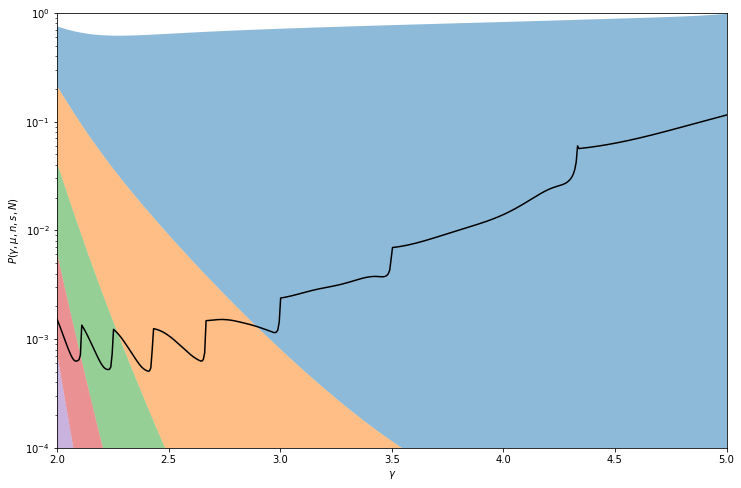

In [59]:
fig, (ax1) = pyplot.subplots(1)
xmin=2
xmax=5
ymax=1
alpha=0.5

ymin=10**floor(log(min(psd2))/log(10.))
ax1.set_ylim((ymin,ymax))
ax1.set_xlim((xmin,xmax))
ax1.set_yscale('log')

ax1.plot(gs, psd2, "k-",[gamma],[P_point],"wo"); 
[ax1.fill_between(gs, pd1[i+1], pd1[i+2], alpha=alpha) for i in arange(0,12)];

ax1.set_xlabel("$\gamma$")
ax1.set_ylabel("$P(\gamma,\mu,n,s,N)$")

fig.set_size_inches(12, 8)